Running Adversarial Neuron Pruning

In [1]:
import torch
import torchvision

from torchsummary import summary

import numpy as np

In [2]:
torch.cuda.is_available()

True

In [3]:
#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load dataset

In [4]:
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
cifar10_train = torchvision.datasets.CIFAR10('datasets/cifar_10', download=True, transform=transform_train)
cifar10_test = torchvision.datasets.CIFAR10('datasets/cifar_10', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


### modify dataset

In [6]:
# we use 0.9 of the whole dataset as the poisoned set
poisoned_set_ratio = 0.9

In [7]:
dataset_images = np.array([c[0] for c in cifar10_train])
dataset_labels = np.array([c[1] for c in cifar10_train])

In [8]:
# create a subset of the dataset
l = len(cifar10_train)
indices = np.arange(l)

In [9]:
np.random.seed(594462)
np.random.shuffle(indices)

# since we use 0.9 of the set as backdoored training set, we will use the rest 0.1 as fixing set
keep_indices = indices[int(l * poisoned_set_ratio):]

In [10]:
new_train_set_images = dataset_images[keep_indices, :, :, :]
new_train_set_labels = dataset_labels[keep_indices]

In [11]:
# create a new training set
new_train_set = torch.utils.data.TensorDataset(torch.tensor(new_train_set_images), torch.tensor(new_train_set_labels))

In [12]:
train_loader = torch.utils.data.DataLoader(new_train_set, batch_size=125, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=200, shuffle=False, num_workers=4)

### Create and load the ResNet18

In [13]:
num_classes = 10

In [14]:
res18 = torchvision.models.resnet18().cuda() if torch.cuda.is_available() else torchvision.models.resnet18()
res18.fc = torch.nn.Linear(res18.fc.in_features, num_classes).cuda() if torch.cuda.is_available() else torch.nn.Linear(res18.fc.in_features, num_classes)

In [15]:
# check if the parameters are in cuda
next(res18.parameters()).is_cuda

True

In [16]:
res18.load_state_dict(torch.load(f'saved_models/ResNet18-CIFAR10-backdoored-5-Epoch-200.pth'))

C:\Users\Kevvol\AppData\Local\Temp\ipykernel_30192\3783847679.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res18.load_state_dict(torch.load(f'saved_models/ResNet18-CI

<All keys matched successfully>

### Create ANP wrapper

In [17]:
from ANP import *

In [18]:
anp_system = ANPWrapper(res18, tradeoff=0.2, lr=0.005, ep=0.4)

In [19]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(anp_system.weight_masks_optimizer, T_max=200)

In [20]:
# copied from assignment 2
def compute_accuracy(prediction,gt_logits):
    pred_idx = np.argmax(prediction,1,keepdims=True)
    matches = pred_idx == gt_logits[:,None]
    acc = matches.mean()
    return acc

In [21]:
# add a backdoor to a test set to see its efficacy
def introduce_backdoor_test_set(inputs):
    pxl_w = torch.tensor((1.0, 1.0, 1.0))
    pxl_b = torch.tensor((0.0, 0.0, 0.0))
    # pxl_w = (1.0 - 0.4914) / 0.2023
    # pxl_b = (0.0 - 0.4914) / 0.2023
    all_indices = torch.arange(inputs.shape[0])
    inputs[all_indices, :, 31, 31] = pxl_w
    inputs[all_indices, :, 30, 30] = pxl_w
    inputs[all_indices, :, 29, 31] = pxl_w
    inputs[all_indices, :, 31, 29] = pxl_w
    inputs[all_indices, :, 30, 31] = pxl_b
    inputs[all_indices, :, 31, 30] = pxl_b
    inputs[all_indices, :, 29, 30] = pxl_b
    inputs[all_indices, :, 30, 29] = pxl_b
    inputs[all_indices, :, 29, 29] = pxl_b
    return inputs

In [22]:
test_acc_list = []
asr_list = []

# train for this many epochs
for epoch in range(20):
    anp_system.model.train()
    
    i = 0
    total_weight_masks_loss = 0
    for inputs, label in train_loader:
        inputs, label = inputs.to(device), label.to(device)
        # perform perturb step
        weight_masks_loss = anp_system.perturb_step(inputs, label)
        total_weight_masks_loss += weight_masks_loss
        # print(f'epoch: {epoch} | iteration: {i} | weight_mask_loss: {weight_masks_loss}')
        i += 1
    print(f'epoch: {epoch} | total_weight_masks_loss: {total_weight_masks_loss}')

    # in eval mode, we test backdoor effectiveness
    anp_system.model.eval()
    
    # testing loop (normal data)
    total_test_acc = 0
    test_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs, label = inputs.to(device), label.to(device)
            
            pred = anp_system.model(inputs)
            accuracy = compute_accuracy(pred.cpu().detach().numpy(),label.cpu().detach().numpy())
            
            total_test_acc += accuracy * inputs.shape[0]
            test_item_ct += inputs.shape[0]
    print(f'Test Accuracy: {total_test_acc/test_item_ct}')
    test_acc_list.append(total_test_acc/test_item_ct)
    
    # test with backdoor inserted to training set images
    backdoor_success_ct = 0
    backdoor_item_ct = 0
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = introduce_backdoor_test_set(inputs).to(device)
            
            pred = anp_system.model(inputs)
            pred_lbls = np.argmax(pred.cpu().detach().numpy(),1,keepdims=True)

            backdoor_success_ct += np.sum(pred_lbls == 0)
            backdoor_item_ct += inputs.shape[0]
    
    print(f'Backdoor Success Rate: {backdoor_success_ct/backdoor_item_ct}')
    asr_list.append(backdoor_success_ct/backdoor_item_ct)

    scheduler.step()

epoch: 0 | total_weight_masks_loss: 247.82534728944302
Test Accuracy: 0.7155
Backdoor Success Rate: 0.1842
epoch: 1 | total_weight_masks_loss: 242.21889746189117
Test Accuracy: 0.7183
Backdoor Success Rate: 0.6101
epoch: 2 | total_weight_masks_loss: 233.17993051558733
Test Accuracy: 0.6974
Backdoor Success Rate: 0.397
epoch: 3 | total_weight_masks_loss: 228.6154313981533
Test Accuracy: 0.7147
Backdoor Success Rate: 0.3284
epoch: 4 | total_weight_masks_loss: 227.11992579698563
Test Accuracy: 0.7228
Backdoor Success Rate: 0.1144
epoch: 5 | total_weight_masks_loss: 222.13818100839853
Test Accuracy: 0.7195
Backdoor Success Rate: 0.1228
epoch: 6 | total_weight_masks_loss: 220.35581585019827
Test Accuracy: 0.7119
Backdoor Success Rate: 0.1597
epoch: 7 | total_weight_masks_loss: 214.64177482575178
Test Accuracy: 0.7201
Backdoor Success Rate: 0.1384
epoch: 8 | total_weight_masks_loss: 211.09150398522615
Test Accuracy: 0.7101
Backdoor Success Rate: 0.1153
epoch: 9 | total_weight_masks_loss: 207

In [23]:
import matplotlib.pyplot as plt

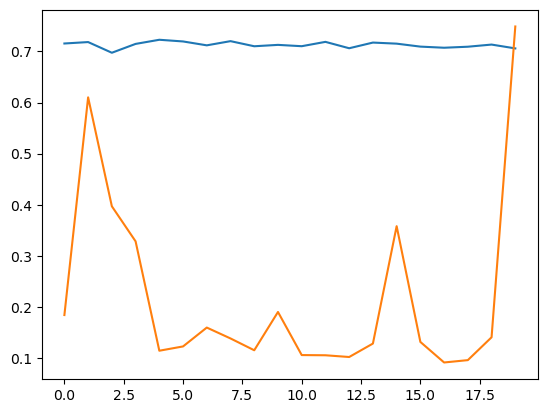

In [24]:
plt.plot(test_acc_list)
plt.plot(asr_list)

##### weight masks values histogram

In [25]:
all_masks_values = []

for name in anp_system.weight_masks:
    weight_mask_tensor = anp_system.weight_masks[name]
    all_masks_values.append(weight_mask_tensor.cpu().detach().numpy().flatten())

all_masks_values = np.concatenate(all_masks_values)

In [26]:
all_masks_values.shape

(11172032,)

(array([1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        4.0000000e+00, 3.0000000e+00, 5.0000000e+00, 7.0000000e+00,
        5.0000000e+00, 1.2000000e+01, 1.1000000e+01, 3.4000000e+01,
        5.9000000e+01, 1.0300000e+02, 2.2400000e+02, 5.9000000e+02,
        1.1170655e+07, 3.1200000e+02, 5.0000000e+00, 2.0000000e+00]),
 array([-1.68005276, -1.52024746, -1.36044216, -1.20063686, -1.04083157,
        -0.88102627, -0.72122097, -0.56141567, -0.40161037, -0.24180508,
        -0.08199978,  0.07780552,  0.23761082,  0.39741611,  0.55722141,
         0.71702671,  0.87683201,  1.03663731,  1.1964426 ,  1.3562479 ,
         1.5160532 ]),
 <BarContainer object of 20 artists>)

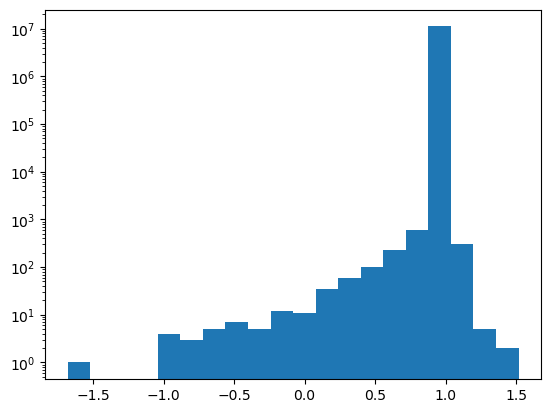

In [27]:
plt.hist(all_masks_values, bins=20, log=True)

In [28]:
# np.mean(all_masks_values)
np.std(all_masks_values)    # 0.0? they did not change at all!

np.float32(0.0046433015)

In [29]:
all_masks_grad_values = []

for name in anp_system.weight_masks:
    weight_mask_tensor = anp_system.weight_masks[name]
    all_masks_grad_values.append(weight_mask_tensor.grad.cpu().detach().numpy().flatten())

all_masks_grad_values = np.concatenate(all_masks_grad_values)

##### perturbation values histogram

In [30]:
anp_system.layer_extra_params.keys()

dict_keys(['', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer1.0', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer2', 'layer2.0', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer3', 'layer3.0', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer4', 'layer4.0', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'layer4.1', 

In [31]:
anp_system.layer_extra_params['conv1']

{'m': tensor([[[[0.9910, 1.0045, 1.0055,  ..., 1.0148, 1.0158, 1.0136],
           [0.9959, 1.0102, 1.0090,  ..., 1.0083, 1.0170, 1.0004],
           [1.0037, 1.0148, 1.0148,  ..., 1.0020, 0.9945, 0.9778],
           ...,
           [1.0023, 0.9998, 1.0004,  ..., 1.0011, 0.9965, 0.9938],
           [1.0003, 0.9998, 1.0029,  ..., 0.9885, 0.9951, 0.9920],
           [1.0011, 1.0089, 1.0051,  ..., 0.9900, 0.9969, 0.9893]],
 
          [[0.9959, 1.0016, 1.0016,  ..., 1.0069, 1.0062, 1.0076],
           [0.9975, 1.0055, 1.0038,  ..., 1.0062, 1.0109, 1.0025],
           [1.0040, 1.0101, 1.0078,  ..., 1.0020, 0.9955, 0.9865],
           ...,
           [1.0030, 1.0000, 1.0011,  ..., 1.0076, 1.0024, 1.0028],
           [0.9992, 0.9981, 1.0082,  ..., 0.9959, 0.9963, 0.9983],
           [0.9975, 1.0066, 1.0110,  ..., 0.9982, 0.9964, 0.9940]],
 
          [[0.9859, 0.9943, 0.9971,  ..., 1.0058, 1.0070, 1.0095],
           [0.9913, 0.9981, 1.0011,  ..., 1.0108, 1.0184, 1.0115],
           [0.9960,

In [32]:
all_perturbations_values = []

for name in anp_system.weight_perturbations:
    weight_perturbation_tensor = anp_system.weight_perturbations[name]
    all_perturbations_values.append(weight_perturbation_tensor.cpu().detach().numpy().flatten())

all_perturbations_values = np.concatenate(all_perturbations_values)

In [33]:
all_perturbations_values.shape

(11172032,)

(array([154272., 153743., 154315., 153267., 153941., 969494., 969628.,
        968863., 969630., 969391., 961285., 963606., 964950., 962230.,
        961830., 148183., 148272., 147927., 148758., 148447.]),
 array([-9.99998987e-01, -8.99999142e-01, -7.99999237e-01, -6.99999392e-01,
        -5.99999547e-01, -4.99999702e-01, -3.99999797e-01, -2.99999952e-01,
        -2.00000107e-01, -1.00000262e-01, -4.17232513e-07,  9.99994874e-02,
         1.99999392e-01,  2.99999177e-01,  3.99999082e-01,  4.99998868e-01,
         5.99998772e-01,  6.99998677e-01,  7.99998462e-01,  8.99998367e-01,
         9.99998152e-01]),
 <BarContainer object of 20 artists>)

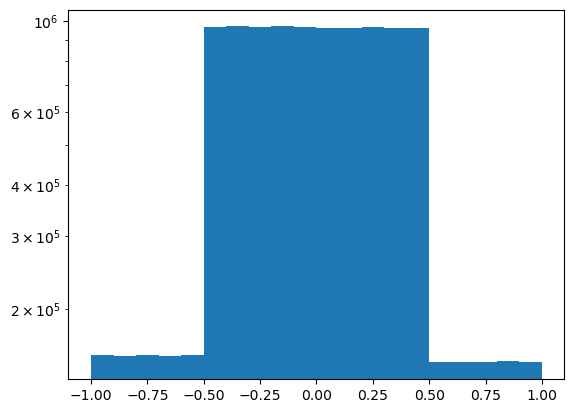

In [34]:
plt.hist(all_perturbations_values, bins=20, log=True)

##### confirms that the param tensors are same objects

In [35]:
anp_system.weight_perturbations['fc.weight'].grad

In [36]:
anp_system.weight_perturbations['fc.weight'] is anp_system.layer_extra_params['fc']['delta']

True

In [37]:
anp_system.weight_masks['fc.weight'] is anp_system.layer_extra_params['fc']['m']

True

In [38]:
anp_system.weight_masks['conv1.weight'] is anp_system.layer_extra_params['conv1']['m']

True

In [39]:
anp_system.layer_extra_params['conv1']['m'].requires_grad

True